In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

import time

import networks

import data_gen

%matplotlib notebook
plt.ion()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # I don't have a GPU to test this

<IPython.core.display.Javascript object>


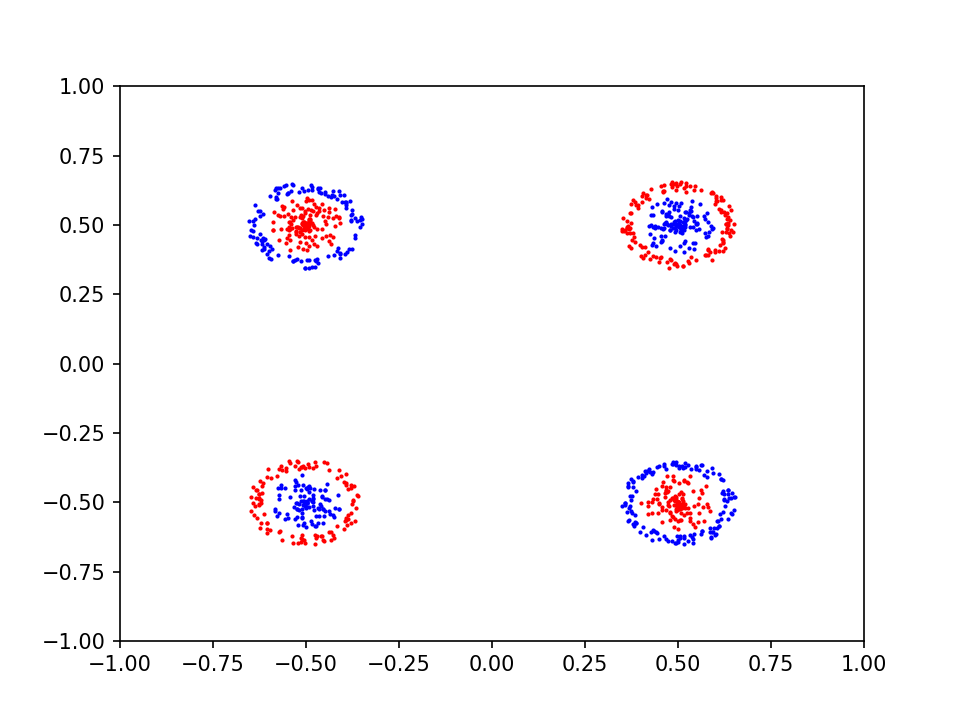

In [17]:
# Plot the data generation function to ensure it is correct
fig, ax = plt.subplots()
fig.show()
inputVals, targetVals = data_gen.harderXorVecOut(1000, r1=0.1, alpha=0.2)
data_gen.plotClassifierData(inputVals, targetVals, plot=(fig, ax))
fig.canvas.draw()
fig.canvas.flush_events()

Number of parameters: 94


<IPython.core.display.Javascript object>


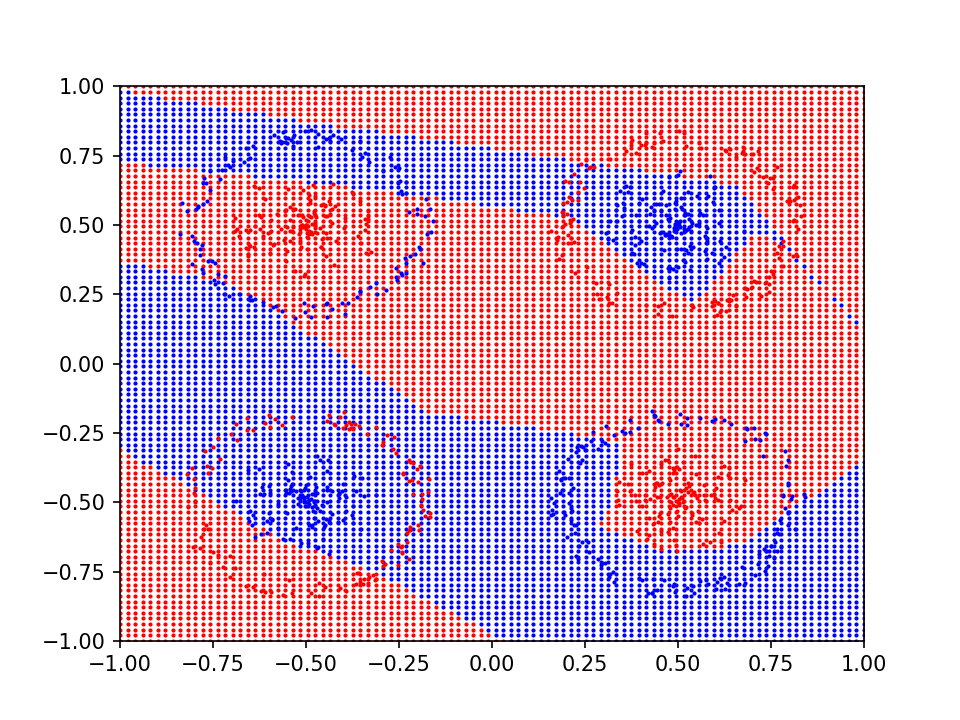

Epoch [0/5000], Loss: 0.7888
Epoch [100/5000], Loss: 0.7299
Epoch [200/5000], Loss: 0.7150
Epoch [300/5000], Loss: 0.7142
Epoch [400/5000], Loss: 0.6954
Epoch [500/5000], Loss: 0.6977
Epoch [600/5000], Loss: 0.6977
Epoch [700/5000], Loss: 0.6979
Epoch [800/5000], Loss: 0.6940
Epoch [900/5000], Loss: 0.6942
Epoch [1000/5000], Loss: 0.6888
Epoch [1100/5000], Loss: 0.6892
Epoch [1200/5000], Loss: 0.6883
Epoch [1300/5000], Loss: 0.6878
Epoch [1400/5000], Loss: 0.6717
Epoch [1500/5000], Loss: 0.6677
Epoch [1600/5000], Loss: 0.6670
Epoch [1700/5000], Loss: 0.6565
Epoch [1800/5000], Loss: 0.6560
Epoch [1900/5000], Loss: 0.6376
Epoch [2000/5000], Loss: 0.6291
Epoch [2100/5000], Loss: 0.6177
Epoch [2200/5000], Loss: 0.6129
Epoch [2300/5000], Loss: 0.6012
Epoch [2400/5000], Loss: 0.6112
Epoch [2500/5000], Loss: 0.6035
Epoch [2600/5000], Loss: 0.5863
Epoch [2700/5000], Loss: 0.5642
Epoch [2800/5000], Loss: 0.5424
Epoch [2900/5000], Loss: 0.5566
Epoch [3000/5000], Loss: 0.5561
Epoch [3100/5000], L

In [18]:
# Data info
num_inputs = 2
num_outputs = 2
num_samples = 1000
data_func = lambda n: data_gen.harderXorVecOut(n, r1=0.2, alpha=0.4)

# Hyper-parameters 
num_epochs = 5000
learning_rate = 0.001
width = 4 # Number of units per hidden layer (same for every layer)
depth = 4 # Number of hidden layers

# Setup for the network
model = networks.ResidualNeuralNetwork(num_inputs, num_outputs, depth, width=width, learning_rate=learning_rate).to(device)

# Count the number of trainable parameters and display it
print('Number of parameters:', model.num_params)

# Set up optimization technique
loss_function = nn.BCEWithLogitsLoss() # Binary cross entropy
#loss_function = nn.CrossEntropyLoss() # Multi-class
#loss_function = nn.L1Loss() # L1 norm
#loss_function = nn.MSELoss() # L2 norm divided by num samples 

# Setup for plotting progress
fig, ax = plt.subplots()
fig.show()
fig.canvas.draw()

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

x = np.reshape(X, 10000)
y = np.reshape(Y, 10000)

X_test = torch.from_numpy(np.vstack((x, y)).T).float()

for epoch in range(num_epochs):
    # Get the training data in a useful data structure
    X_train, y_train = data_func(num_samples)
    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    
    loss = model.train(X_train, y_train, loss_function)
    
    if epoch %100 == 0 :
        # Display the running accuracy
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, loss.item()))
        
        pred = model(X_test).detach().numpy()
        
        # Plot the classification map
        ax.clear()
        
        data_gen.plotClassifierData(X_test, pred, plot=(fig, ax))
        data_gen.plotClassifierData(X_train, y_train, plot=(fig, ax))
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        

In [4]:
def check_test_accuracy(y, y1):
    num_right = 0
    for i in range(len(y1)):
        if y1[i, 0] > y1[i, 1] and y[i, 0] == 1:
            num_right += 1
        elif y1[i, 0] < y1[i, 1] and y[i, 1] == 1:
            num_right += 1
            
    return num_right/len(y1)

In [30]:
widths = range(10, 0, -1)
depths = range(10, 0, -1)

# Data info
num_inputs = 2
num_outputs = 2
num_samples = 100
data_func = lambda n: data_gen.harderXorVecOut(n, r1=0.2, alpha=0.4)

loss_function = nn.BCEWithLogitsLoss()

# Hyper-parameters 
num_epochs = 3500
learning_rate = 0.001

# Make X_test and y_test
X_test, y_test = data_func(num_samples*100)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# f = open('dataPointsLow.txt', 'a')

# f.write('width, depth, accuracies\n')

# f.close()

for iteration in range(10):
    f = open('data/dataPointsLow' + str(iteration) + '.txt', 'a')
    for width in widths:
        for depth in depths:
            model = networks.NeuralNetwork(num_inputs, num_outputs, depth, width=width, learning_rate=learning_rate).to(device)
            f.write(str(width) + ', ' + str(depth) + ', ' + str(model.num_params) + '\n')
            begin = time.time()

            testAcc = []
            trainAcc = []

            for epoch in range(num_epochs):
                # Get the training data in a useful data structure
                X_train, y_train = data_func(num_samples)
                X_train = torch.from_numpy(X_train).float().to(device)
                y_train = torch.from_numpy(y_train).float().to(device)

                loss = model.train(X_train, y_train, loss_function)

                if epoch %100 == 0 :
                    pred = model(X_train).detach().numpy()
                    acc = check_test_accuracy(y_train, pred)
                    trainAcc.append(acc)

                    pred = model(X_test).detach().numpy()
                    acc = check_test_accuracy(y_test, pred)
                    testAcc.append(acc)
                    # Determine what proportion is correct
                    #f.write('(' + str(epoch) + ', ' + str(loss.item()) + ', ' + str(acc) + ')')
                    #print(width, depth, epoch, num_epochs, loss.item(), trainAcc[-1], testAcc[-1])

            f.write('test,' + ','.join(str(acc) for acc in testAcc) + '\n')
            f.write('train,' +  ','.join(str(acc) for acc in trainAcc) + '\n')
            f.write('time, ' + str(time.time()-begin) + '\n')
            print(width, depth, trainAcc[-1], testAcc[-1], time.time() - begin)
    f.close()

1 1 0.43 0.4966 31.21892285346985
1 2 0.46 0.5034 30.318559169769287
1 3 0.43 0.4966 30.38967990875244
1 4 0.5 0.5034 32.311347007751465
1 5 0.49 0.5034 31.3716983795166
1 6 0.49 0.5034 33.15276503562927
1 7 0.54 0.5034 32.29733753204346
1 8 0.49 0.4966 33.37981200218201
1 9 0.61 0.5034 33.723247051239014
1 10 0.61 0.4966 34.57716774940491
2 1 0.53 0.5667 27.673055410385132
2 2 0.49 0.5034 28.8989520072937
2 3 0.51 0.5034 29.886921882629395
2 4 0.64 0.5847 31.008562088012695
2 5 0.48 0.4966 32.020877838134766
2 6 0.5 0.5034 32.914576053619385
2 7 0.54 0.5034 33.644420862197876
2 8 0.51 0.5034 34.37951159477234
2 9 0.55 0.5034 35.30600357055664
2 10 0.41 0.5034 36.17669367790222
3 1 0.5 0.5192 28.101978063583374
3 2 0.66 0.5913 28.905822277069092
3 3 0.59 0.5342 29.97472381591797
3 4 0.67 0.6134 31.09329056739807
3 5 0.53 0.4966 32.12479114532471
3 6 0.62 0.5898 32.97581076622009
3 7 0.67 0.6641 33.94138789176941
3 8 0.52 0.4966 34.85511064529419
3 9 0.5 0.4966 35.55012798309326
3 10 0.

4 10 0.81 0.7677 36.43775796890259
5 1 0.58 0.6016 28.14527463912964
5 2 0.61 0.6588 29.048708200454712
5 3 0.73 0.6785 30.307724714279175
5 4 0.75 0.7447 31.34971261024475
5 5 0.77 0.7113 32.3104202747345
5 6 0.72 0.7287 33.40267848968506
5 7 0.84 0.7924 34.181678771972656
5 8 0.54 0.4966 34.99978423118591
5 9 0.56 0.4966 35.75404095649719
5 10 0.84 0.8689 37.183335304260254
6 1 0.46 0.492 28.04186725616455
6 2 0.71 0.722 29.08306336402893
6 3 0.87 0.8599 30.221051931381226
6 4 0.74 0.7265 31.308884620666504
6 5 0.83 0.8241 31.580687761306763
6 6 0.87 0.8991 33.35739183425903
6 7 0.82 0.7845 34.29068350791931
6 8 0.81 0.807 35.13844656944275
6 9 0.34 0.5034 36.066298961639404
6 10 0.89 0.9189 37.03790473937988
7 1 0.63 0.6296 28.155477285385132
7 2 0.5 0.5293 29.076417922973633
7 3 0.81 0.826 30.328373432159424
7 4 0.81 0.7704 31.623935222625732
7 5 0.72 0.7672 32.115216970443726
7 6 0.87 0.8628 33.61281394958496
7 7 0.84 0.8254 34.493829011917114
7 8 0.86 0.8734 35.343579053878784
7 

8 9 0.87 0.8378 36.77836298942566
8 10 0.42 0.4966 37.59092450141907
9 1 0.62 0.6622 28.217496156692505
9 2 0.68 0.6965 28.625526666641235
9 3 0.77 0.7969 30.748494863510132
9 4 0.82 0.8071 31.977445602416992
9 5 0.92 0.917 33.02840518951416
9 6 0.91 0.9365 34.068504095077515
9 7 0.99 0.9862 35.443174839019775
9 8 0.88 0.9136 36.20917868614197
9 9 0.84 0.8769 37.0825617313385
9 10 0.92 0.8462 38.44906806945801
10 1 0.77 0.7178 27.849573850631714
10 2 0.67 0.8071 29.455990314483643
10 3 0.91 0.8969 30.990756034851074
10 4 1.0 0.9999 32.28092646598816
10 5 0.87 0.8228 33.295188188552856
10 6 0.97 0.9701 34.28517127037048
10 7 0.8 0.8371 35.09512162208557
10 8 0.94 0.9362 36.457260847091675
10 9 0.92 0.904 37.45558762550354
10 10 0.84 0.8462 38.83022117614746
1 1 0.55 0.5285 29.756120443344116
1 2 0.49 0.5034 29.65876340866089
1 3 0.49 0.4966 29.574825048446655
1 4 0.55 0.5034 30.336967945098877
1 5 0.53 0.5034 30.771672010421753
1 6 0.59 0.4966 32.74446177482605
1 7 0.49 0.5034 31.819303

2 8 0.51 0.5034 34.51560378074646
2 9 0.42 0.4966 35.069610595703125
2 10 0.51 0.5034 36.15062403678894
3 1 0.55 0.5181 28.03295612335205
3 2 0.64 0.5779 29.064977407455444
3 3 0.44 0.5034 30.088316679000854
3 4 0.58 0.6161 31.1279034614563
3 5 0.47 0.5034 32.07766509056091
3 6 0.54 0.5427 32.89498829841614
3 7 0.48 0.5034 33.88711452484131
3 8 0.49 0.5034 34.579890966415405
3 9 0.48 0.4966 35.35750365257263
3 10 0.52 0.4966 36.26483917236328
4 1 0.55 0.5276 28.19720959663391
4 2 0.64 0.5721 29.10824179649353
4 3 0.45 0.5034 30.14080572128296
4 4 0.62 0.6094 30.366993188858032
4 5 0.68 0.7262 32.140464305877686
4 6 0.61 0.5034 33.07773780822754
4 7 0.58 0.6911 33.9163544178009
4 8 0.51 0.5034 34.66993570327759
4 9 0.51 0.4966 35.559030055999756
4 10 0.56 0.6116 36.49543070793152
5 1 0.58 0.6037 28.025130033493042
5 2 0.73 0.6772 29.223748922348022
5 3 0.58 0.6182 30.410671949386597
5 4 0.83 0.8157 31.56469178199768
5 5 0.49 0.4966 32.388330936431885
5 6 0.58 0.7013 33.23591446876526
5 

6 6 0.55 0.5822 33.27156901359558
6 7 0.53 0.5034 34.17328429222107
6 8 0.8 0.8449 35.037275075912476
6 9 0.43 0.4966 35.87000751495361
6 10 0.55 0.5034 37.094260692596436
7 1 0.63 0.649 28.18149995803833
7 2 0.75 0.7113 29.17301917076111
7 3 0.8 0.7751 30.314420461654663
7 4 0.73 0.7618 31.541748762130737
7 5 0.82 0.8477 32.5655415058136
7 6 0.85 0.8382 33.454551219940186
7 7 0.93 0.9198 34.631964445114136
7 8 0.72 0.7326 35.32752990722656
7 9 0.88 0.882 36.238595962524414
7 10 0.76 0.7422 37.49932336807251
8 1 0.47 0.5191 28.27291965484619
8 2 0.78 0.7395 29.34660768508911
8 3 0.77 0.7987 30.673843145370483
8 4 0.47 0.5034 31.765124082565308
8 5 0.96 0.9281 32.870566606521606
8 6 0.78 0.7916 33.74285316467285
8 7 0.94 0.9279 34.70580077171326
8 8 0.87 0.8684 35.44615721702576
8 9 0.5 0.5034 36.73819899559021
8 10 0.79 0.8047 37.76020002365112
9 1 0.61 0.5945 28.24642276763916
9 2 0.72 0.6901 29.404719352722168
9 3 0.86 0.8799 30.821927785873413
9 4 0.87 0.8349 31.982259511947632
9 5 

In [5]:
widths = range(30, 0, -1)
depths = range(30, 0, -1)

# Data info
num_inputs = 1
num_outputs = 1
num_samples = 100
wid = 1
freq = 5
power = 10
cutoff = 0.5
data_func = lambda n: data_gen.regressionProblem(n, wid, freq, power, cutoff)

loss_function = nn.MSELoss() # L2 norm divided by num samples 

# Hyper-parameters 
num_epochs = 2000
learning_rate = 0.001

# Make X_test and y_test
X_test = np.linspace(-1, 1, 10000)[:, np.newaxis]
fx = np.abs(X_test)
sinFx = (np.cos(freq*np.pi*fx) + 1)/2
y_test = np.multiply(sinFx, np.exp(-power*np.maximum(0.0, np.power(fx, 2)-cutoff)))
X_test = torch.from_numpy(X_test.T).float().to(device)
y_test = torch.from_numpy(y_test.T).float().to(device)

# f = open('dataPointsLow.txt', 'a')

# f.write('width, depth, accuracies\n')

# f.close()
dictThing = {}

for iteration in range(1, 5):
    f = open('dataRegressionResnetWide/dataPointsLow' + str(iteration) + '.txt', 'a')
    for width in widths:
        for depth in depths:
            model = networks.ResidualNeuralNetworkWide(num_inputs, num_outputs, depth, width=width, learning_rate=learning_rate).to(device)
            f.write(str(width) + ', ' + str(depth) + ', ' + str(model.num_params) + '\n')
            begin = time.time()

            testAcc = []
            trainAcc = []

            for epoch in range(num_epochs):
                # Get the training data in a useful data structure
                X_train, y_train = data_func(num_samples)
                X_train = torch.from_numpy(X_train).float().to(device)
                y_train = torch.from_numpy(y_train).float().to(device)

                loss = model.train(X_train, y_train, loss_function)

                if epoch %100 == 0 :
                    acc = np.mean(np.square(y_train.detach().numpy() - model(X_train).detach().numpy()))
                    trainAcc.append(acc)

                    pred = model(X_test.transpose(0, 1)).detach().numpy()
                    acc = np.mean(np.square(y_test.detach().numpy().T - pred))
                    testAcc.append(acc)
                    # Determine what proportion is correct
                    #f.write('(' + str(epoch) + ', ' + str(loss.item()) + ', ' + str(acc) + ')')
                    #print(width, depth, epoch, num_epochs, loss.item(), trainAcc[-1], testAcc[-1])
            
            dictThing.setdefault((width, depth), []).append(pred)
            f.write('test,' + ','.join(str(acc) for acc in testAcc) + '\n')
            f.write('train,' +  ','.join(str(acc) for acc in trainAcc) + '\n')
            f.write('time, ' + str(time.time()-begin) + '\n')
            print(width, depth, trainAcc[-1], testAcc[-1], time.time() - begin)
    f.close()

30 30 1.14484e-05 1.15129e-05 45.66218662261963
30 29 4.94695e-05 4.50372e-05 44.59610342979431
30 28 0.00934675 0.00953416 43.012009382247925
30 27 0.000445727 0.000385993 41.59743523597717
30 26 0.00400363 0.00379672 38.51191759109497
30 25 1.7317e-05 1.67758e-05 36.870558738708496
30 24 8.39276e-05 8.70098e-05 35.41961121559143
30 23 0.000132774 0.000129363 34.086557388305664
30 22 7.77621e-06 8.7109e-06 32.420225381851196
30 21 0.00123087 0.00119752 31.265069723129272
30 20 0.000960009 0.00128815 29.29821252822876
30 19 1.18544e-05 3.26964e-05 28.301815032958984
30 18 0.000958174 0.000943229 26.619037866592407
30 17 8.61444e-06 9.65857e-06 25.381197452545166
30 16 0.00440676 0.00362621 24.198139190673828
30 15 0.000111089 0.000119075 23.05282688140869
30 14 0.00115577 0.00143019 20.620341062545776
30 13 0.000100097 9.59332e-05 19.4115207195282
30 12 8.44953e-05 9.22062e-05 18.19984006881714
30 11 0.000467912 0.000445693 16.561665058135986
30 10 0.00123741 0.00139635 15.407544374465

25 7 0.000191425 0.000194062 10.228590726852417
25 6 4.43192e-05 3.88611e-05 8.707297563552856
25 5 0.000138963 0.000178765 7.609882116317749
25 4 8.93288e-05 0.000111603 6.324060440063477
25 3 0.000255749 0.000232658 4.658604860305786
25 2 0.00120427 0.00134021 4.373178720474243
25 1 0.0203135 0.0182475 2.64451003074646
24 30 0.000467651 0.000583756 40.844767332077026
24 29 5.82728e-06 5.86251e-06 39.08946466445923
24 28 8.45237e-05 8.27147e-05 37.229835987091064
24 27 0.00104618 0.0011584 35.40550518035889
24 26 5.07933e-06 5.79389e-06 34.30254244804382
24 25 5.29238e-05 7.66533e-05 36.43021845817566
24 24 0.0012069 0.0014035 33.381168842315674
24 23 1.75337e-05 1.79777e-05 33.093202352523804
24 22 3.28354e-05 3.85915e-05 30.178521633148193
24 21 1.25367e-05 1.65824e-05 27.951619386672974
24 20 0.00252147 0.0020351 27.063744068145752
24 19 3.73369e-05 3.52012e-05 26.23098587989807
24 18 6.73759e-05 6.91933e-05 28.26098370552063
24 17 0.000149211 0.00017769 23.222342252731323
24 16 0.

19 14 0.00223855 0.00197018 15.02721095085144
19 13 0.000645585 0.00062862 17.494072437286377
19 12 7.50801e-06 1.92149e-05 16.01529312133789
19 11 2.1346e-05 2.08542e-05 15.04814887046814
19 10 0.000175148 0.000264696 13.875591039657593
19 9 0.00136632 0.00119505 12.896876811981201
19 8 0.000999337 0.000968353 11.18041729927063
19 7 0.000193945 0.000228906 9.326876640319824
19 6 0.000786505 0.000837257 8.670289754867554
19 5 8.38214e-05 8.52339e-05 7.184957504272461
19 4 0.000935378 0.000723377 6.374621391296387
19 3 0.000505496 0.000749632 4.807682514190674
19 2 0.000932769 0.0011709 3.359229803085327
19 1 0.0544931 0.0507358 2.2481493949890137
18 30 0.00331636 0.00332322 34.83129358291626
18 29 1.04616e-05 1.21623e-05 31.65079951286316
18 28 0.000630311 0.00059281 30.35490918159485
18 27 6.80412e-05 7.74636e-05 29.06444764137268
18 26 4.88207e-05 3.63197e-05 27.83626079559326
18 25 0.000161654 0.000172717 25.855316400527954
18 24 0.000123384 0.000192519 27.332904815673828
18 23 0.00

13 21 0.000346759 0.000398712 20.32235550880432
13 20 0.000139271 0.000144264 19.10420846939087
13 19 0.00580005 0.0066955 18.134835720062256
13 18 1.96867e-05 2.85688e-05 16.99523091316223
13 17 0.000171041 0.00019081 16.59675884246826
13 16 8.78158e-05 9.46834e-05 14.83631157875061
13 15 8.48771e-05 8.57494e-05 18.6181857585907
13 14 0.000282172 0.000290399 17.152180671691895
13 13 0.000208158 0.000237324 15.98565411567688
13 12 8.77057e-05 9.37803e-05 15.244267463684082
13 11 8.084e-05 0.000108164 14.147960901260376
13 10 3.90119e-05 4.05696e-05 12.519110202789307
13 9 9.11775e-05 9.63892e-05 11.465924501419067
13 8 0.00026887 0.000280433 10.455928564071655
13 7 0.000793555 0.000865534 8.760725736618042
13 6 0.000701693 0.000567895 7.71160364151001
13 5 0.000522553 0.00048067 7.357155799865723
13 4 0.00475846 0.00491991 5.59307861328125
13 3 0.0479421 0.0543617 4.325522184371948
13 2 0.00156929 0.00172106 3.2461867332458496
13 1 0.0729599 0.0802142 2.1282522678375244
12 30 0.0001992

7 24 0.000179056 0.000246728 25.50493097305298
7 23 0.00153717 0.00164278 18.338348150253296
7 22 0.00187075 0.00266356 17.588151693344116
7 21 0.000389506 0.000914182 16.752806663513184
7 20 0.0002582 0.000336523 22.0988552570343
7 19 0.000123225 0.000176017 20.222020387649536
7 18 0.0357457 0.0343756 18.286175966262817
7 17 0.000404321 0.000576847 16.996185064315796
7 16 0.000780177 0.0015415 16.433799028396606
7 15 0.0385921 0.0451662 15.768252849578857
7 14 0.00020088 0.0002527 15.002399921417236
7 13 0.000163492 0.000167392 13.87569260597229
7 12 0.0145557 0.0131885 13.011606216430664
7 11 0.000365252 0.000524403 11.8386869430542
7 10 0.000522819 0.000520537 10.896395683288574
7 9 0.0726576 0.0722179 9.399836540222168
7 8 0.00127491 0.00149998 8.396264553070068
7 7 0.000810639 0.000892013 7.733874320983887
7 6 0.02292 0.0244989 7.292328119277954
7 5 0.0701463 0.0492482 6.118026971817017
7 4 0.0697641 0.0773775 5.082870721817017
7 3 0.0639525 0.0716461 3.88446307182312
7 2 0.029777

1 14 0.118915 0.113135 11.836859464645386
1 13 0.129046 0.1131 12.2329261302948
1 12 0.119083 0.113095 11.073192358016968
1 11 0.098167 0.113107 10.363316774368286
1 10 0.115625 0.113097 9.36914348602295
1 9 0.114909 0.113097 7.8860297203063965
1 8 0.107976 0.113117 7.394596815109253
1 7 0.149471 0.133804 7.056741952896118
1 6 0.0916545 0.118953 5.515219688415527
1 5 0.118554 0.11311 4.832433462142944
1 4 0.117096 0.11455 4.203297138214111
1 3 0.117304 0.113103 3.251748561859131
1 2 0.117079 0.113097 2.5919387340545654
1 1 0.128947 0.113104 1.9039926528930664
30 30 2.69115e-05 2.40664e-05 46.09657549858093
30 29 0.00168758 0.00156174 44.98464822769165
30 28 0.000134732 0.000193147 43.2566921710968
30 27 2.9012e-05 2.77268e-05 41.11512327194214
30 26 9.33832e-06 8.10032e-06 39.198309898376465
30 25 0.000276222 0.000332584 37.76039385795593
30 24 9.54072e-05 9.17696e-05 36.06212615966797
30 23 0.000633004 0.000691799 33.954392433166504
30 22 0.000369864 0.000322863 32.892802000045776
30 

25 19 0.000198686 0.000191301 25.930736780166626
25 18 0.000198492 0.000207163 24.94099998474121
25 17 0.000175571 0.000135005 23.80970048904419
25 16 3.898e-05 2.90811e-05 22.640042781829834
25 15 3.44779e-05 3.48979e-05 20.739985942840576
25 14 0.000205029 0.000204741 19.16911506652832
25 13 2.53747e-05 1.93431e-05 18.109233856201172
25 12 0.000392598 0.000346776 16.920851945877075
25 11 0.000177371 0.000164431 15.539174556732178
25 10 0.000644434 0.000649068 14.57619047164917
25 9 8.83452e-05 7.60981e-05 12.953698873519897
25 8 0.000225706 0.000279519 12.034694194793701
25 7 0.000219802 0.000252723 10.254251718521118
25 6 0.00272662 0.00276782 8.857420206069946
25 5 4.6306e-05 5.84778e-05 7.4998085498809814
25 4 0.000182288 0.00016253 6.548937797546387
25 3 0.00667883 0.0061102 4.882062196731567
25 2 0.00504689 0.00632347 4.023891448974609
25 1 0.0431231 0.0525717 2.6040871143341064
24 30 0.000825585 0.000754278 41.3202600479126
24 29 2.81424e-05 3.29794e-05 38.33003282546997
24 28 

19 26 0.000159293 0.000210594 28.32712960243225
19 25 8.00966e-05 7.85234e-05 27.06810426712036
19 24 0.00299972 0.00302765 25.582855224609375
19 23 0.000198692 0.000255772 24.266929149627686
19 22 2.269e-05 2.02668e-05 24.237475872039795
19 21 0.000254104 0.000238163 22.224027395248413
19 20 0.00101546 0.00109036 20.522725820541382
19 19 0.000655647 0.000558528 19.499637126922607
19 18 0.00163296 0.00181909 18.548744201660156
19 17 0.000133795 0.000142014 18.056134462356567
19 16 0.00228027 0.00184786 17.38642978668213
19 15 6.59642e-05 6.817e-05 16.798471212387085
19 14 6.03106e-05 5.30147e-05 18.37256669998169
19 13 6.41151e-05 7.97164e-05 17.418824672698975
19 12 0.000259083 0.000216241 16.369390726089478
19 11 6.94777e-05 0.000126037 15.193357706069946
19 10 4.13704e-05 4.74158e-05 14.206219911575317
19 9 0.000136142 0.00013982 12.472635269165039
19 8 6.78618e-05 7.33184e-05 11.697833061218262
19 7 0.000142553 0.000116812 9.51120901107788
19 6 0.00010432 8.41921e-05 8.484310388565

14 3 0.00076211 0.000845959 4.212723731994629
14 2 0.0822817 0.0820348 3.058757781982422
14 1 0.0761252 0.0661081 2.2065749168395996
13 30 0.00418902 0.00475093 31.373860836029053
13 29 0.000353348 0.000324995 28.98208212852478
13 28 2.66812e-05 3.20785e-05 27.562421560287476
13 27 0.00865394 0.00712018 26.534985780715942
13 26 0.000394431 0.000352046 25.037963390350342
13 25 0.00157192 0.00156102 24.18527126312256
13 24 0.00010068 0.000110477 22.705039739608765
13 23 6.98635e-05 7.27389e-05 21.841319799423218
13 22 9.58914e-05 9.93058e-05 20.73669743537903
13 21 0.000113187 0.000118247 19.988602876663208
13 20 0.00199951 0.00160766 18.715160608291626
13 19 5.94924e-05 6.3729e-05 24.70528244972229
13 18 0.000512331 0.000628556 17.325806140899658
13 17 0.000116714 9.31389e-05 17.614811420440674
13 16 0.000220893 0.000289937 17.02964687347412
13 15 0.000101051 0.000128528 18.66214394569397
13 14 0.000647453 0.000668474 17.184702396392822
13 13 6.95428e-05 7.50303e-05 15.91726016998291
13

8 8 0.00153031 0.00184259 8.505911827087402
8 7 0.0644602 0.0647269 7.708320140838623
8 6 0.0277988 0.0285196 7.071429014205933
8 5 0.00411733 0.00608716 6.374441385269165
8 4 0.00585561 0.00546021 4.896089315414429
8 3 0.0849093 0.0782631 3.6772654056549072
8 2 0.0324521 0.0292581 2.947443962097168
8 1 0.0932145 0.0864812 2.0753891468048096
7 30 0.00021891 0.000314597 24.845514059066772
7 29 5.75222e-05 5.52173e-05 23.833123922348022
7 28 0.000316658 0.000287652 22.475948572158813
7 27 3.19779e-05 4.02353e-05 21.793386459350586
7 26 0.0116469 0.0133983 20.823842763900757
7 25 0.000206908 0.000226009 21.52010989189148
7 24 0.000424753 0.000368422 21.159299612045288
7 23 0.0374675 0.0500508 18.679475784301758
7 22 0.000102635 0.000116646 17.55553650856018
7 21 0.00885601 0.00627043 17.5862295627594
7 20 0.00227274 0.00184641 22.200685024261475
7 19 0.000160576 0.000197932 20.24643301963806
7 18 0.0453276 0.0488005 18.009960889816284
7 17 0.0336796 0.0288106 17.60166049003601
7 16 0.0022

1 28 0.114348 0.113095 23.780611753463745
1 27 0.0998668 0.113094 23.087614059448242
1 26 0.105215 0.113097 22.275583028793335
1 25 0.140262 0.113093 20.367157220840454
1 24 0.117747 0.113093 18.8983416557312
1 23 0.108163 0.113097 18.055100440979004
1 22 0.121557 0.113094 17.421282291412354
1 21 0.118728 0.113329 17.17978549003601
1 20 0.137287 0.113094 16.230167388916016
1 19 0.0944862 0.113102 15.646003007888794
1 18 0.135871 0.113618 15.656503438949585
1 17 0.129892 0.113095 14.50120234489441
1 16 0.0971788 0.113094 13.359953165054321
1 15 0.103922 0.10086 13.41209602355957
1 14 0.12175 0.113101 11.505106925964355
1 13 0.104925 0.113125 11.681623458862305
1 12 0.106597 0.113097 10.350886583328247
1 11 0.106411 0.113095 10.515533208847046
1 10 0.113221 0.113104 9.151048183441162
1 9 0.101173 0.113096 8.06313705444336
1 8 0.12746 0.113097 7.8473451137542725
1 7 0.112505 0.113137 6.230777025222778
1 6 0.11991 0.1131 5.5709168910980225
1 5 0.117921 0.113171 5.212593078613281
1 4 0.1074

26 1 0.0132725 0.0178012 2.7761919498443604
25 30 0.000309522 0.000311145 42.926486015319824
25 29 0.00059039 0.000694958 40.476584911346436
25 28 1.59055e-05 1.29479e-05 38.585370779037476
25 27 0.00359919 0.00567111 37.50575613975525
25 26 4.92332e-05 4.37234e-05 35.92709493637085
25 25 0.000221761 0.000207756 34.35495328903198
25 24 0.000331531 0.00037231 33.34352087974548
25 23 0.00920986 0.00933563 31.371429920196533
25 22 2.90615e-05 2.71159e-05 29.868772268295288
25 21 0.000223251 0.000198484 28.622859477996826
25 20 2.59395e-05 3.84767e-05 27.377204418182373
25 19 8.81016e-06 1.06881e-05 26.458765506744385
25 18 3.45873e-05 4.07141e-05 25.273170948028564
25 17 0.000322626 0.000404694 23.7881977558136
25 16 7.09819e-05 7.80574e-05 22.752328157424927
25 15 0.000825794 0.000699179 21.41829514503479
25 14 3.26974e-05 3.949e-05 19.497287273406982
25 13 0.00417903 0.00261915 18.257967233657837
25 12 4.16424e-05 5.09653e-05 16.931978464126587
25 11 1.17849e-05 1.34729e-05 15.844632148

20 8 0.000126462 0.000116834 11.32504415512085
20 7 0.000148236 0.000202314 9.631489992141724
20 6 6.08387e-05 4.98673e-05 8.662166118621826
20 5 9.77489e-05 0.000102318 7.156585693359375
20 4 6.95837e-05 7.7611e-05 6.240756034851074
20 3 0.00219654 0.00499713 5.4386303424835205
20 2 0.0166741 0.0157487 4.028521299362183
20 1 0.0165837 0.012825 2.4852805137634277
19 30 0.000304339 0.000345723 37.246845722198486
19 29 0.00011916 8.60466e-05 33.40900278091431
19 28 0.000160336 0.000138624 35.393301010131836
19 27 0.000163966 0.000215744 35.05037999153137
19 26 2.98142e-05 3.94564e-05 32.80066180229187
19 25 8.83645e-05 9.20141e-05 32.8843514919281
19 24 0.000340807 0.000315285 27.325607776641846
19 23 7.24371e-05 9.67445e-05 27.062312841415405
19 22 0.00130716 0.00114722 23.091107845306396
19 21 0.000482692 0.000420372 21.85874581336975
19 20 0.000675756 0.000826168 21.513334035873413
19 19 8.93e-06 1.05971e-05 20.71186399459839
19 18 0.00035428 0.000320472 18.47257971763611
19 17 0.0004

14 15 0.00190808 0.00252034 19.331958770751953
14 14 4.83166e-05 4.89906e-05 17.377219915390015
14 13 0.000257766 0.000268418 16.342684984207153
14 12 0.00081934 0.00082539 15.394247770309448
14 11 6.41176e-05 3.8011e-05 14.305281162261963
14 10 6.70907e-05 5.96698e-05 12.934139966964722
14 9 0.000160959 0.000170016 11.822964191436768
14 8 0.000659297 0.00068512 10.240595579147339
14 7 0.000683034 0.000667255 8.674978733062744
14 6 0.0014999 0.00176772 8.017005681991577
14 5 0.000808179 0.000775831 7.3841071128845215
14 4 0.00423555 0.00387888 5.7048704624176025
14 3 0.00169864 0.00132508 4.009061813354492
14 2 0.00697164 0.0081534 3.0514883995056152
14 1 0.058358 0.0587262 2.1941022872924805
13 30 0.000655867 0.000750262 36.53399395942688
13 29 0.000113998 0.000142106 29.3049418926239
13 28 2.02911e-05 2.35029e-05 28.394680500030518
13 27 0.00119048 0.00149931 26.65735149383545
13 26 2.13134e-05 1.92125e-05 26.068775177001953
13 25 0.000480617 0.000444158 24.00525999069214
13 24 0.000

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


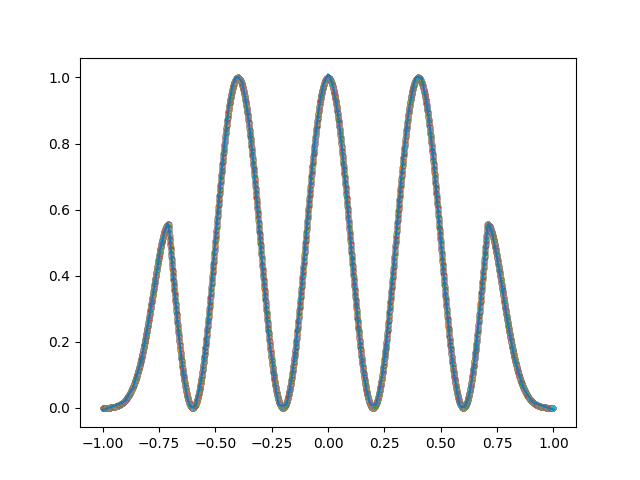

In [73]:
fig, ax = plt.subplots()
fig.show()
ax.plot(X_test.numpy(), y_test.numpy(), '.');
ax.plot(X_test.numpy().T, dictThing[(20, 20)][0]);

<IPython.core.display.Javascript object>


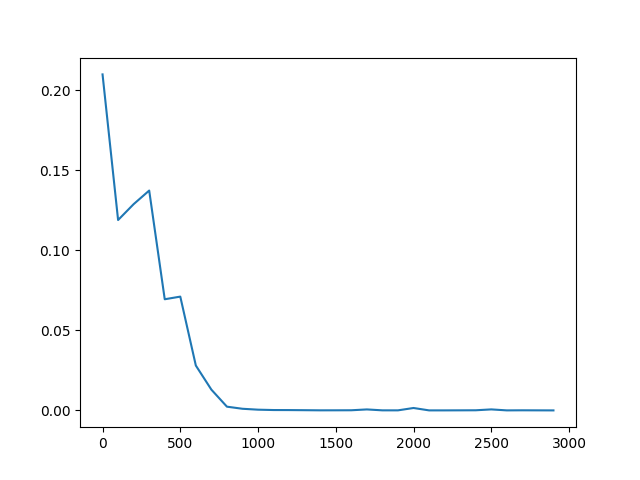

In [74]:
fig, ax = plt.subplots()
fig.show()
ax.plot(range(0, 3000, 100), trainAcc)